In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tqdm

c:\anaconda3\envs\py_397\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\anaconda3\envs\py_397\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\anaconda3\envs\py_397\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="naver_shopping.txt")

('naver_shopping.txt', <http.client.HTTPMessage at 0x2a374c4b9a0>)

# 데이터 불러오기

In [31]:
df = pd.read_csv("./data/naver_shopping.txt", sep="\t", header=None, encoding="utf-8-sig")
df.columns = ['score', 'reviews']
print(len(df))
df.head()

200000


,score,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [32]:
df['label'] = np.select([df.score > 3], [1], default=0)
df.head()

,score,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [33]:
df_comment = pd.read_csv("./data/total_comment_data.csv", encoding="utf-8-sig")
df_comment

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_21116\3408060966.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comment = pd.read_csv("./data/total_comment_data.csv", encoding="utf-8-sig")


,Unnamed: 0,youtube_id,comment,like_num,comment_date,owner_channel,video_num
0,0,songheepark9809,다양한 체험들 알려주셔서 고마워요!! 영상에 나온 거 다 너무 재밌어보여요밍고님 영...,0.0,3개월 전,@Mingokim,0
1,1,moonsunkang6257,후쿠오카 가고싶다,0.0,3개월 전,@Mingokim,0
2,2,userck8uk7tu5q,10년전 후쿠오카에 갔었는데. \n이영상을 보니 또한번 가야겠어요. \n보이스도...,0.0,3개월 전,@Mingokim,0
3,3,bobslee6308,"밍고짱 넘 부럽당,,후쿠오카에 액티비티가 이렇게 많았구남,, 재밌었겠댜🫶",0.0,3개월 전,@Mingokim,0
4,4,heeeunbyun1238,후쿠오카 놀러가야지,0.0,3개월 전,@Mingokim,0
...,...,...,...,...,...,...,...
468107,468107,userkm3oh6br6o,언니 오프닝노래 먼지알수있을까요 ㅠㅜ. 넘 조은거..,0.0,3개월 전,희주,9
468108,468108,cocomik5140,미니쇼핑하울하실때입으신블랙팬츠정보도궁금해요,0.0,3개월 전,희주,9
468109,468109,uservu8on4xm8h,언니가 입은 니트 조끼 어디거예요?,0.0,3개월 전,희주,9
468110,468110,akinuakinu2087,NaN,0.0,3개월 전,희주,9


In [34]:
df_labeled = pd.read_csv("./data/labeled_data/label_comment_df.csv", encoding="utf-8-sig")
df_labeled

,comment,label
0,언니 화장 너무 잘해용,1
1,언니 영상볼 때마다 옷 정보 궁금했는데 더보기란에 적어주셔서 감사해욤,1
2,당장 올리브영 가야해~~ 저도 금발이라 이번 메이크업 너무 좋아요>_<,1
3,진짜 제 모델이자 워너비 ㅠㅠ 사랑해요 언니 항상 언니같은 삶을 꿈만 꾸며 사네요 ...,1
4,탈색 넘 고생인것 같아요ㅠㅠ 하지만 너무너무 잘어울리는 샌..,1
...,...,...
4731,지금도 그저 예쁨,1
4732,성형은 사실 .. 한다고 김태희만큼 이뻐지는거 아님 그냥 안하고 사는게 맞는거타요....,0
4733,하는것도 나쁘지 않을것 같은데욥ㅋㅋ,0
4734,재수술하면 지금보다 성형 더 티날 듯,0


# 데이터 중복 제거 및 결측치 처리

In [35]:
df.drop_duplicates(subset=['reviews'], inplace=True) # Drop duplicate reviews
print(df.isnull().values.any())
print(len(df))

df['reviews'].replace('', np.nan, inplace=True)
print(df.isnull().sum())

False
199908
score      0
reviews    0
label      0
dtype: int64


In [36]:
df_comment.drop_duplicates(subset=['comment'], inplace=True) # Drop duplicate reviews
print(df_comment.isnull().values.any())
print(len(df_comment))

df_comment['comment'].replace('', np.nan, inplace=True)
print(df_comment.isnull().sum())

True
452316
Unnamed: 0        0
youtube_id       45
comment           1
like_num          0
comment_date      0
owner_channel     0
video_num         0
dtype: int64


In [37]:
df_comment.dropna(how='any', inplace=True) # Drop NaN
print(df_comment.isnull().sum())

Unnamed: 0       0
youtube_id       0
comment          0
like_num         0
comment_date     0
owner_channel    0
video_num        0
dtype: int64


In [38]:
df_labeled.drop_duplicates(subset=['comment'], inplace=True) # Drop duplicate reviews
print(df_labeled.isnull().values.any())
print(len(df_labeled))

df_labeled['comment'].replace('', np.nan, inplace=True)
print(df_labeled.isnull().sum())

False
4736
comment    0
label      0
dtype: int64


# 문장 데이터 전처리

In [39]:
text=''
review=[]
for each_line in df['reviews']:
    review.append(each_line)
#리뷰 잘 들어갔는지 확인
review[2]

'아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.'

In [40]:

#불용어 제거
import re
def clean_str(text):
    pattern = '[^ㄱ-ㅎㅏ-ㅣ가-힣]'
    text = re.sub(pattern=pattern, repl=' ', string=text)
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    return text   

review_=[]
for i in review:  #문자가 들어있을때는 인덱스 사용하면 안됨!!!!
    a=clean_str(i)
    review_.append(a)  #불용어제거한 review 저장


In [41]:
review[4] #불용어 제거 전

'민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ'

In [42]:
review_[4]

'민트색상 예뻐요  옆 손잡이는 거는 용도로도 사용되네요 '

In [43]:
text=''
comment=[]
for each_line in df_comment['comment']:
    comment.append(each_line)
#리뷰 잘 들어갔는지 확인
comment[2]

'10년전 후쿠오카에 갔었는데.  \n이영상을 보니 또한번 가야겠어요.  \n보이스도후쿠오카.  기억했다가 꼭 들려봐야지.'

In [44]:
comment_=[]
for i in comment:  #문자가 들어있을때는 인덱스 사용하면 안됨!!!!
    a=clean_str(i)
    comment_.append(a)  #불용어제거한 review 저장


In [45]:
comment[2]

'10년전 후쿠오카에 갔었는데.  \n이영상을 보니 또한번 가야겠어요.  \n보이스도후쿠오카.  기억했다가 꼭 들려봐야지.'

In [46]:
comment_[2]

'  년전 후쿠오카에 갔었는데    이영상을 보니 또한번 가야겠어요    보이스도후쿠오카   기억했다가 꼭 들려봐야지 '

In [47]:
text=''
labeled_comment=[]
for each_line in df_labeled['comment']:
    labeled_comment.append(each_line)
#리뷰 잘 들어갔는지 확인
labeled_comment[2]

'당장 올리브영 가야해~~ 저도 금발이라 이번 메이크업 너무 좋아요>_<'

In [48]:
labeled_comment_=[]
for i in labeled_comment:  #문자가 들어있을때는 인덱스 사용하면 안됨!!!!
    a=clean_str(i)
    labeled_comment_.append(a) 

In [49]:
labeled_comment[2]

'당장 올리브영 가야해~~ 저도 금발이라 이번 메이크업 너무 좋아요>_<'

In [50]:
labeled_comment_[2]

'당장 올리브영 가야해   저도 금발이라 이번 메이크업 너무 좋아요   '

# 불용어 처리

In [51]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
import nltk
from konlpy.tag import Okt; 
okt=Okt()  #오픈 소스 한국어 분석기

#리뷰하나씩 형태소 추출
a= len(review_) #불용어 제거한 리뷰
token_review_list=[]
for i in tqdm.tqdm(range(0,a)): # 리뷰하나당 처리하기위해 for문 
    token_review=okt.morphs(review_[i])   # morphs=형태소 추출.review_=전처리한 리뷰.
    stopwords_removed_sentence = [word for word in token_review if not word in stopwords] # 불용어 제거
    token_review_list.append(stopwords_removed_sentence) #하나의 리스트를 만들어서 df에 추가해야함.
df['token_review']=token_review_list #형태소단위로 나누어진 리뷰저장
df

In [19]:
df.to_csv('./data/token_output.csv', encoding='utf-8-sig')

In [52]:
df = pd.read_csv("./data/token_output.csv", encoding="utf-8-sig")
df

,Unnamed: 0,score,reviews,label,token_review
0,0,5,배공빠르고 굿,1,"['배공', '빠르고', '굿']"
1,1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0,"['택배', '엉망', '이네', '용', '저희', '집', '밑', '층', '..."
2,2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1,"['아주', '좋아요', '바지', '정말', '좋아서', '개', '더', '구매..."
3,3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0,"['선물', '용', '빨리', '받아서', '전달', '했어야', '하는', '상..."
4,4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1,"['민트', '색상', '예뻐요', '옆', '손잡이', '거', '용', '도로'..."
...,...,...,...,...,...
199903,199995,2,장마라그런가!!! 달지않아요,0,"['장마', '라', '그', '런가', '달', '지', '않아요']"
199904,199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1,"['다이슨', '케이스', '구매', '했어요', '다이슨', '슈퍼소닉', '드라..."
199905,199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1,"['로드샾', '에서', '사는것보다', '세배', '저렴하네요', '자주', '용..."
199906,199998,5,넘이쁘고 쎄련되보이네요~,1,"['넘', '이쁘고', '쎄련', '되', '보이네요']"


In [53]:
import nltk
from konlpy.tag import Okt; 
okt=Okt()  #오픈 소스 한국어 분석기

#리뷰하나씩 형태소 추출
a= len(comment_) #불용어 제거한 리뷰
token_review_list=[]
for i in tqdm.tqdm(range(0,a)): # 리뷰하나당 처리하기위해 for문 
    token_review=okt.morphs(comment_[i])   # morphs=형태소 추출.review_=전처리한 리뷰.
    stopwords_removed_sentence = [word for word in token_review if not word in stopwords] # 불용어 제거
    token_review_list.append(stopwords_removed_sentence) #하나의 리스트를 만들어서 df에 추가해야함.
df_comment['token_comment']=token_review_list #형태소단위로 나누어진 리뷰저장
df_comment

100%|██████████| 452270/452270 [3:38:33<00:00, 34.49it/s]   


,Unnamed: 0,youtube_id,comment,like_num,comment_date,owner_channel,video_num,token_comment
0,0,songheepark9809,다양한 체험들 알려주셔서 고마워요!! 영상에 나온 거 다 너무 재밌어보여요밍고님 영...,0.0,3개월 전,@Mingokim,0,"[다양한, 체험, 알려주셔서, 고마워요, 영상, 나온, 거, 다, 너무, 재밌어, ..."
1,1,moonsunkang6257,후쿠오카 가고싶다,0.0,3개월 전,@Mingokim,0,"[후쿠오카, 가고싶다]"
2,2,userck8uk7tu5q,10년전 후쿠오카에 갔었는데. \n이영상을 보니 또한번 가야겠어요. \n보이스도...,0.0,3개월 전,@Mingokim,0,"[년전, 후쿠오카, 갔었는데, 영상, 을, 보니, 또한, 번, 가야겠어요, 보이스,..."
3,3,bobslee6308,"밍고짱 넘 부럽당,,후쿠오카에 액티비티가 이렇게 많았구남,, 재밌었겠댜🫶",0.0,3개월 전,@Mingokim,0,"[밍고짱, 넘, 부럽당, 후쿠오카, 액, 티비, 티, 이렇게, 많았구, 남, 재밌었..."
4,4,heeeunbyun1238,후쿠오카 놀러가야지,0.0,3개월 전,@Mingokim,0,"[후쿠오카, 놀러, 가야, 지]"
...,...,...,...,...,...,...,...,...
468106,468106,Whiteqf3d,3:30 행사가셔서 입은 원피스?? 정보 궁금해여.. 다 넘 이뿌,0.0,3개월 전,희주,9,"[행사, 가셔서, 입은, 원피스, 정보, 궁금해여, 다, 넘, 이뿌]"
468107,468107,userkm3oh6br6o,언니 오프닝노래 먼지알수있을까요 ㅠㅜ. 넘 조은거..,0.0,3개월 전,희주,9,"[언니, 오프닝, 노래, 먼지, 알수있을까요, 넘, 조은, 거]"
468108,468108,cocomik5140,미니쇼핑하울하실때입으신블랙팬츠정보도궁금해요,0.0,3개월 전,희주,9,"[미니, 쇼핑, 하울, 하실, 때, 입으신, 블랙, 팬츠, 정보, 궁금해요]"
468109,468109,uservu8on4xm8h,언니가 입은 니트 조끼 어디거예요?,0.0,3개월 전,희주,9,"[언니, 입은, 니트, 조끼, 어디, 거, 예요]"


In [54]:
print(df_comment.isnull().values.any())

False


In [55]:
df_comment.to_csv('./data/df_comment_tokened.csv', encoding='utf-8-sig')

In [56]:
import nltk
from konlpy.tag import Okt; 
okt=Okt()  #오픈 소스 한국어 분석기

#리뷰하나씩 형태소 추출
a= len(labeled_comment_) #불용어 제거한 리뷰
token_review_list=[]
for i in tqdm.tqdm(range(0,a)): # 리뷰하나당 처리하기위해 for문 
    token_review=okt.morphs(labeled_comment_[i])   # morphs=형태소 추출.review_=전처리한 리뷰.
    stopwords_removed_sentence = [word for word in token_review if not word in stopwords] # 불용어 제거
    token_review_list.append(stopwords_removed_sentence) #하나의 리스트를 만들어서 df에 추가해야함.
df_labeled['token_comment']=token_review_list #형태소단위로 나누어진 리뷰저장
df_labeled

100%|██████████| 4736/4736 [00:39<00:00, 119.15it/s]


,comment,label,token_comment
0,언니 화장 너무 잘해용,1,"[언니, 화장, 너무, 해용]"
1,언니 영상볼 때마다 옷 정보 궁금했는데 더보기란에 적어주셔서 감사해욤,1,"[언니, 영상, 볼, 때, 마다, 옷, 정보, 궁금했는데, 더, 보기, 란, 적어주..."
2,당장 올리브영 가야해~~ 저도 금발이라 이번 메이크업 너무 좋아요>_<,1,"[당장, 올리브영, 가야해, 저, 금발, 이라, 이번, 메이크업, 너무, 좋아요]"
3,진짜 제 모델이자 워너비 ㅠㅠ 사랑해요 언니 항상 언니같은 삶을 꿈만 꾸며 사네요 ...,1,"[진짜, 제, 모델, 이자, 워, 너비, 사랑, 해요, 언니, 항상, 언니, 같은,..."
4,탈색 넘 고생인것 같아요ㅠㅠ 하지만 너무너무 잘어울리는 샌..,1,"[탈색, 넘, 고생, 인, 것, 같아요, 하지만, 너무, 너무, 어울리는, 샌]"
...,...,...,...
4731,지금도 그저 예쁨,1,"[지금, 그저, 예쁨]"
4732,성형은 사실 .. 한다고 김태희만큼 이뻐지는거 아님 그냥 안하고 사는게 맞는거타요....,0,"[성형, 사실, 한다고, 김태희, 만큼, 이뻐지는거, 아님, 그냥, 안, 하고, 사..."
4733,하는것도 나쁘지 않을것 같은데욥ㅋㅋ,0,"[하는것도, 나쁘지, 않을것, 같은데, 욥]"
4734,재수술하면 지금보다 성형 더 티날 듯,0,"[재수술, 하면, 지금, 보다, 성형, 더, 티날, 듯]"


In [57]:
print(df_labeled.isnull().values.any())

False


In [58]:
df_labeled.to_csv('./data/df_labeled_tokened.csv', encoding='utf-8-sig')

Train Reviews :  149931
Test_Reviews :  49977
   label  count
0      0  74918
1      1  75013


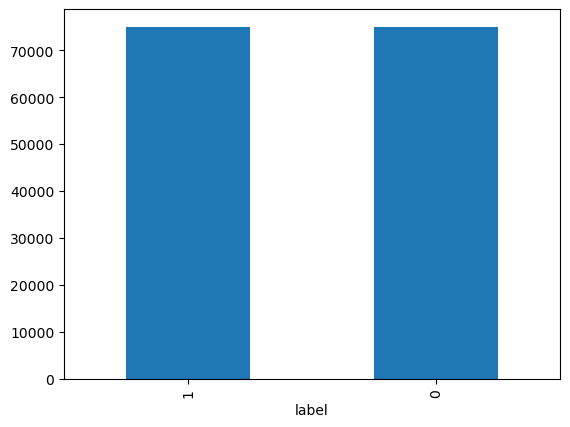

In [30]:
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)
print("Train Reviews : ", len(train_data))
print("Test_Reviews : ", len(test_data))
train_data['label'].value_counts().plot(kind='bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['token_review'])

In [23]:
print(tokenizer.word_index)

{'너무': 1, '배송': 2, '요': 3, '좋아요': 4, '안': 5, '재구매': 6, '구매': 7, '다': 8, '사용': 9, '로': 10, '을': 11, '그냥': 12, '제품': 13, '했는데': 14, '가격': 15, '보다': 16, '생각': 17, '하고': 18, '같아요': 19, '입니다': 20, '주문': 21, '맛': 22, '고': 23, '많이': 24, '더': 25, '못': 26, '때': 27, '별로': 28, '해서': 29, '만': 30, '것': 31, '사이즈': 32, '포장': 33, '에서': 34, '개': 35, '서': 36, '합니다': 37, '네': 38, '거': 39, '좋네요': 40, '상품': 41, '했어요': 42, '빠르고': 43, '정말': 44, '다른': 45, '냄새': 46, '부분': 47, '제': 48, '이라': 49, '인데': 50, '하나': 51, '나': 52, '넘': 53, '두': 54, '아주': 55, '샀는데': 56, '좋습니다': 57, '진짜': 58, '저': 59, '할': 60, '만족합니다': 61, '좋은': 62, '또': 63, '조금': 64, '구입': 65, '반품': 66, '딱': 67, '아이': 68, '정도': 69, '해': 70, '느낌': 71, '맘': 72, '아직': 73, '완전': 74, '중': 75, '좋고': 76, '감사합니다': 77, '엄청': 78, '게': 79, '일': 80, '용': 81, '처음': 82, '비': 83, '있어요': 84, '면': 85, '사진': 86, '않고': 87, '지': 88, '디자인': 89, '효과': 90, '라': 91, '보고': 92, '다시': 93, '대비': 94, '상태': 95, '선물': 96, '추천': 97, '써': 98, '그': 99, '빠른': 100, '구': 101, '한번': 102, '

In [24]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91378
등장 빈도가 2번 이하인 희귀 단어의 수: 61678
단어 집합에서 희귀 단어의 비율: 67.49764713607213
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.010815633466797


In [25]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 29701


In [26]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(train_data['token_review'])
X_train = tokenizer.texts_to_sequences(train_data['token_review'])
X_test = tokenizer.texts_to_sequences(test_data['token_review'])

In [27]:
print(X_train[:3])

[[32, 2233, 269, 287, 171, 105, 74, 324, 3, 9126, 782, 38, 3, 24, 1617, 1031, 384, 90, 4], [1476, 4085, 3090, 3125, 257], [13, 137, 6065, 315, 2693, 496, 5, 934, 52, 29, 93, 2929, 167, 496, 93, 13478, 7332, 8, 3967, 3, 66, 17800]]


In [28]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [29]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [30]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

149700
149700


c:\anaconda3\envs\py_397\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 56
리뷰의 평균 길이 : 11.729044756179025


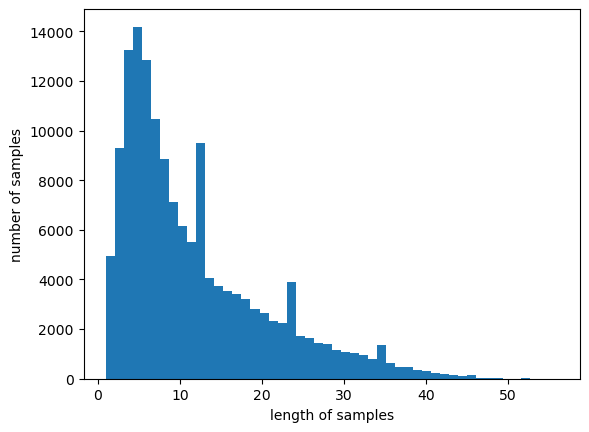

In [31]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 45
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 99.90113560454242


In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
X_train.shape, X_test.shape

In [37]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1872/1872 [==============================] - ETA: 0s - loss: 0.2891 - acc: 0.8880
Epoch 1: val_acc improved from -inf to 0.90671, saving model to best_model.h5
1872/1872 [==============================] - 314s 163ms/step - loss: 0.2891 - acc: 0.8880 - val_loss: 0.2493 - val_acc: 0.9067
Epoch 2/15
1872/1872 [==============================] - ETA: 0s - loss: 0.2299 - acc: 0.9163
Epoch 2: val_acc improved from 0.90671 to 0.91366, saving model to best_model.h5
1872/1872 [==============================] - 273s 146ms/step - loss: 0.2299 - acc: 0.9163 - val_loss: 0.2349 - val_acc: 0.9137
Epoch 3/15
1871/1872 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9245
Epoch 3: val_acc improved from 0.91366 to 0.91369, saving model to best_model.h5
1872/1872 [==============================] - 216s 115ms/step - loss: 0.2105 - acc: 0.9245 - val_loss: 0.2273 - val_acc: 0.9137
Epoch 4/15
1872/1872 [==============================] - ETA: 0s - loss: 0.1969 - acc: 0.9301
Epoch 4

In [38]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 35s 22ms/step - loss: 0.2320 - acc: 0.9166

 테스트 정확도: 0.9166


In [42]:
temp = loaded_model.evaluate(X_test, y_test)

1562/1562 [==============================] - 33s 21ms/step - loss: 0.2320 - acc: 0.9166


In [44]:
y_pred = loaded_model.predict(X_test)

In [40]:
y_pred

array([[0.0011791 ],
       [0.09107804],
       [0.9831708 ],
       ...,
       [0.99650127],
       [0.9582143 ],
       [0.00469893]], dtype=float32)

In [45]:
y_pred_label = np.round(y_pred.flatten(), 0)
y_pred_label

array([0., 0., 1., ..., 1., 1., 0.], dtype=float32)

In [46]:
from sklearn.metrics import classification_report

# classification_report를 사용하여 다양한 분류 평가 지표 출력
report = classification_report(y_test, y_pred_label)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     25037
           1       0.91      0.92      0.92     24940

    accuracy                           0.92     49977
   macro avg       0.92      0.92      0.92     49977
weighted avg       0.92      0.92      0.92     49977



In [47]:
from sklearn.metrics import recall_score, precision_score, f1_score
recall = recall_score(y_test, y_pred_label)
precision = precision_score(y_test, y_pred_label)
f1 = f1_score(y_test, y_pred_label)

print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

Recall: 0.9233761026463513
Precision: 0.9107051053901214
F1 Score: 0.9169968343719513


In [48]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)